# Projet 5: Segmentez des clients d'un site e-commerce

## Notebook d'essais

### Importation des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import squarify
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from math import pi
from sklearn import decomposition ,metrics
from sklearn.cluster import KMeans , AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score,silhouette_score , silhouette_samples,  make_scorer,v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as shc
from yellowbrick.cluster import KElbowVisualizer , SilhouetteVisualizer
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
from sklearn.metrics import v_measure_score
from scipy import stats

### Chargement de données 
Dans cette partie, nous utiliserons pour nos différentes modélisations, le fichier client créé précedemment.

In [2]:
#chargement de données 
df=pd.read_csv('df_clients.csv')
df.head()

,customer_unique_id,region,customer_city,rfm_recence,rfm_frequence,rfm_montant,review_mean_score,nombre_produits,nombre_commande,panier_moyen,echeances,moyen_paiement_prefere,best_category,order_purchase_timestamp,dernier_achat
0,0000366f3b9a7992bf8c76cfdf3221e2,sud_est,cajamar,112.0,1.0,141.90,5.0,1.0,1.0,141.90,8.0,credit_card,home,2018-05-10 10:56:27,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,sud_est,osasco,115.0,1.0,27.19,4.0,1.0,1.0,27.19,1.0,credit_card,beauty,2018-05-07 11:11:27,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,sud,sao jose,537.0,1.0,86.22,3.0,1.0,1.0,86.22,8.0,credit_card,office,2017-03-10 21:05:03,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,nord,belem,321.0,1.0,43.62,4.0,1.0,1.0,43.62,4.0,credit_card,tech,2017-10-12 20:29:41,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,sud_est,sorocaba,288.0,1.0,196.89,5.0,1.0,1.0,196.89,6.0,credit_card,tech,2017-11-14 19:45:42,2017-11-14 19:45:42


Durant notre analyse exploratoire du notebook 1, le calcul des skew(le coefficient d'asymétrie) a montré que plusieurs variables quantitatives étaient anormalement distribuées. Nous utiliserons une transformation en log pour normaliser ces variables.

In [3]:
df_log=df.copy()

In [4]:
#selection des variables à transformer
var_to_log=var_to_log=df_log.select_dtypes(include='number').columns.to_list()

In [5]:
#la variable 'rfm_recence' a un skew proche de 0
var_to_log.remove('rfm_recence')

In [6]:
var_to_log

['rfm_frequence',
 'rfm_montant',
 'review_mean_score',
 'nombre_produits',
 'nombre_commande',
 'panier_moyen',
 'echeances']

In [7]:
#transformation en log
for i in var_to_log:
    df_log[i] = np.log1p(df_log[i])

Nous pouvons voir l'effet des transformation en log sur les graphiques suivants.

In [8]:
#fonction de calcul de skew et de réalisation de displot
def check_skew(df, column):
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])
    plt.title('Distribution de ' + column)
    sns.distplot(df[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\42103479.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




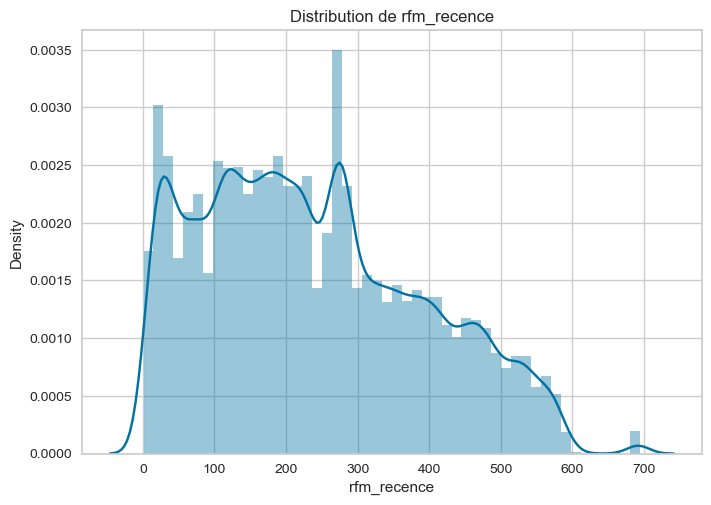

rfm_recence's: Skew: 0.44337291191045225, : SkewtestResult(statistic=52.0117852299677, pvalue=0.0)


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\42103479.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




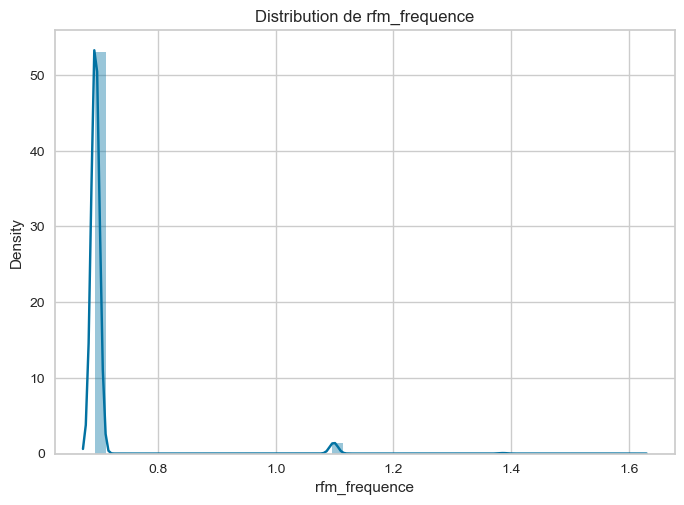

rfm_frequence's: Skew: 6.200367208612954, : SkewtestResult(statistic=272.89902416132907, pvalue=0.0)


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\42103479.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




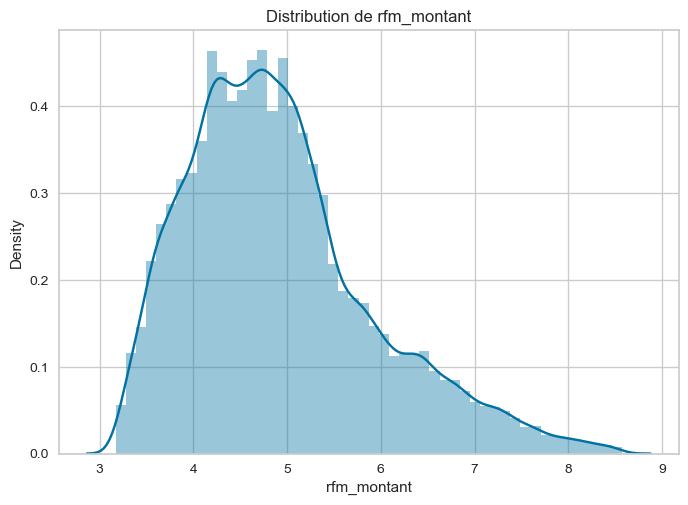

rfm_montant's: Skew: 0.8494383636477276, : SkewtestResult(statistic=91.0967841903878, pvalue=0.0)


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\42103479.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




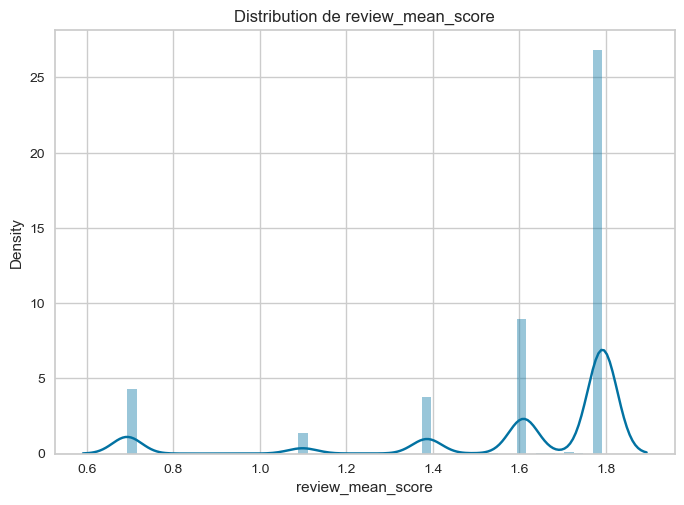

review_mean_score's: Skew: -1.883518208988838, : SkewtestResult(statistic=-157.53766062866976, pvalue=0.0)


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\42103479.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




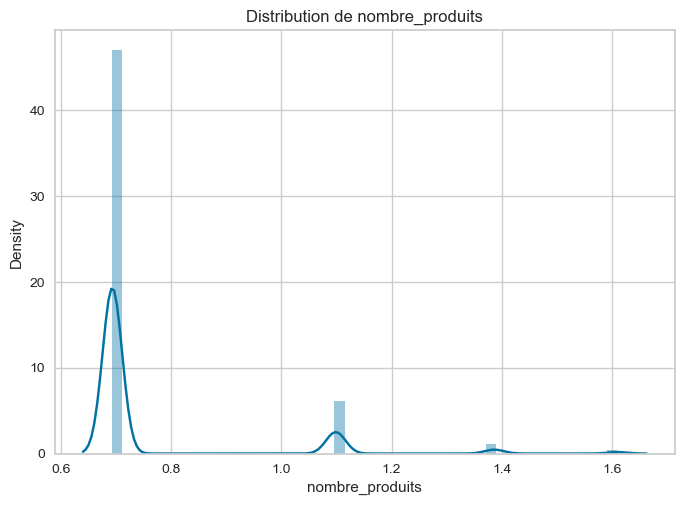

nombre_produits's: Skew: 2.6437578791429903, : SkewtestResult(statistic=189.39940462082097, pvalue=0.0)


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\42103479.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




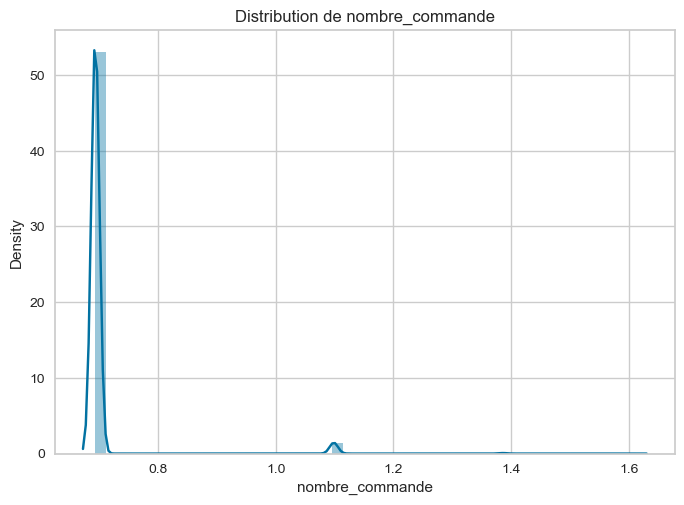

nombre_commande's: Skew: 6.200367208612954, : SkewtestResult(statistic=272.89902416132907, pvalue=0.0)


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\42103479.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




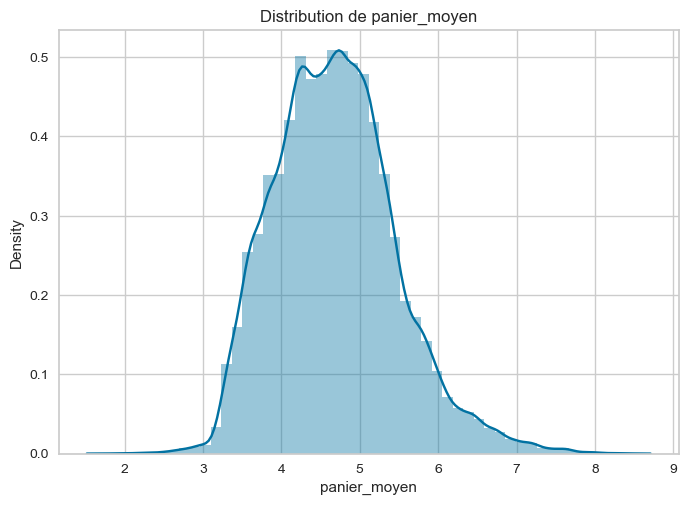

panier_moyen's: Skew: 0.5150951559265152, : SkewtestResult(statistic=59.59830929872129, pvalue=0.0)


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\42103479.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




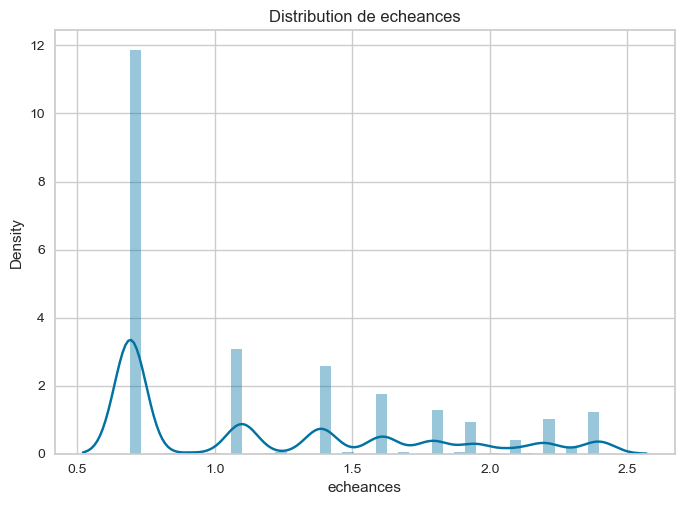

echeances's: Skew: 0.7880134756201096, : SkewtestResult(statistic=85.7760864954469, pvalue=0.0)


In [9]:
for col in df_log.select_dtypes(include='number').columns:
    check_skew(df_log, col)

In [10]:
#fonction ppour selectionner les varaibles nécessaires à notre modélisation
def selection_features(data, features):
    data=data[features]
    Y=data['customer_unique_id'].values
    data.set_index('customer_unique_id', inplace=True)
    X=data.values
    return X, Y

In [11]:
#fonction scaler 
def scaler(df):
    #cols=df.columns
    scaler=StandardScaler()
    df=scaler.fit_transform(df)
    #df=pd.DataFrame(df,columns=[cols])
    return df

## K-Means
#### Fonctionnement
L’algorithme K-means identifie un certain nombre de centroïdes dans un ensemble de données, un centroïde étant la moyenne arithmétique de tous les points de données appartenant à un cluster particulier.

L’algorithme attribue ensuite chaque point de données au cluster le plus proche en essayant de maintenir les clusters aussi petits que possible (le terme « means » dans K-means fait référence à la tâche consistant à faire la moyenne des données ou à trouver le centroïde).

#### Détermination de la valeur K (le nombre de clusters optimal)
##### - La méthode d’Elbow
Selon l’algorithme de K-Means, on doit définir au préalable le nombre K de clusters. Le problème qui se pose et de trouver un K optimal. L’une des méthodes les plus populaires pour y arriver est la méthode d’Elbow. Elle s’appuie sur la notion d’inertie. On définit cette dernière comme ceci : la somme des distances euclidiennes entre chaque point et son centroïde associé.

L’idée est d’exécuter le clustering k-means pour une gamme de clusters k et pour chaque valeur, nous calculons l’inertie intraclasse.

Lorsque l’on trace les distorsions et que le tracé ressemble à un bras, le « coude » (le point d’inflexion de la courbe) est la meilleure valeur de k.


##### - Le coefficient de silhouette
Une approche plus précise mais qui requiert plus de temps de calcul est  le coefficient de silhouette. Il mesure la similitude d’un point de données à l’intérieur d’un groupe par rapport à d’autres groupes.

Ce coefficient peut varier entre -1 et +1. Un coefficient proche de +1 signifie que l’observation est située bien à l’intérieur de son propre cluster, tandis qu’un coefficient proche de 0 signifie qu’elle se situe près d’une frontière ; enfin, un coefficient proche de -1 signifie que l’observation est associée au mauvais cluster. 

In [12]:
# Fonction k-means pour déterminer le nombre de clusters et affichage du diagramme du coude
def calcul_nbre_cluster_kmeans(df_in, kmin, kmax, method):
    # Instantiate the clustering model and visualizer
    model = KMeans(init='k-means++')
    
    if method == 'distortion':
        visualizer = KElbowVisualizer(model, k=(kmin,kmax), metric=method)
        
    elif method == 'silhouette':
        visualizer = KElbowVisualizer(model, k=(kmin,kmax), metric=method, timings=True)

    # Entraînement des données
    visualizer.fit(df_in)        
    
    # Affichage du résultat
    visualizer.show()
    visualizer.poof()
    return None

In [13]:

def clients_par_clusters(clusters_labels):
    '''
    Affiche la répartition des clients par cluster
    Parameters
    ----------
    clusters_labels : la séries des labels des clusters, obligatoire.
    Returns
    -------
    None.
    '''
    ax1 = plt.gca()

    # DataFrame de travail
    series_client_cluster = pd.Series(clusters_labels).value_counts()
    nb_client = series_client_cluster.sum()
    df_visu_client_cluster = pd.DataFrame(
        {'Clusters': series_client_cluster.index,
         'Nb_clients': series_client_cluster.values})
    df_visu_client_cluster['%'] = round(
        (df_visu_client_cluster['Nb_clients']) * 100 / nb_client, 2)
    df_visu_client_cluster = df_visu_client_cluster.sort_values(by='Clusters')
    display(df_visu_client_cluster.style.hide_index())
    
     # Barplot de la distribution
    sns.set_style('white')
    sns.barplot(x='Clusters', y='Nb_clients',
                data=df_visu_client_cluster, color='SteelBlue', ax=ax1)
    ax1.set_ylabel('Nombre de clients)', fontsize=12)
    ax1.set_xlabel('Clusters', fontsize=12)
    ax1.set_title('Nombre de clients par clusters', fontsize=14)
    plt.gcf().set_size_inches(6, 4)
    plt.grid(False)
    plt.show()


In [70]:
#fonction de modélisation et d'affichage des clusters
def clustering(X,k,n):
    '''
    X= données a l'entrée,
    k Nombre de clusters
    n= nombre de composantes PCA pour la projection
    '''
    #kMeans
    model= KMeans(n_clusters=k)
    model.fit(X)
    model_labels=model.labels_
    print('le score est',model.inertia_)
    #Apc pour une meilleure projection
    pca = PCA(n_components=n)
    pca.fit(X)
    X_trans=pca.transform(X)
    plt.scatter(X_trans[:,0], X_trans[:,1], c=model.labels_)
    plt.title('la projection des segments')
    return model.labels_

#### Segmentation RFM

In [15]:
feats=['customer_unique_id','rfm_recence', 'rfm_frequence', 'rfm_montant']

In [16]:
#créons une table 'data' avec les 3 features RFM
data=df[feats]
data.set_index('customer_unique_id', inplace=True)
table=data.copy()

In [17]:
#Sélection de la table contenant les variables transfomées en log
X, Y= selection_features(df_log,feats)
#standardisation de notre table
X=scaler(X)

##### Détermination du nombre de clusters optimal

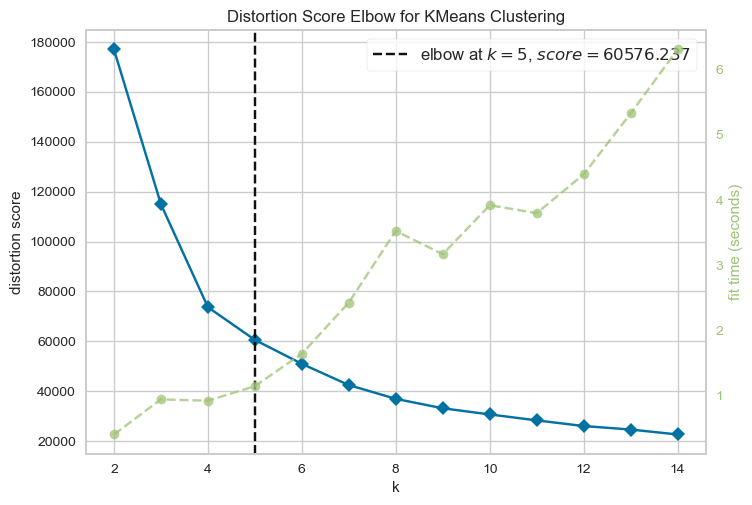

In [18]:
# Appel de la fonction pour détermination de nombre de cluster par la méthode du coude
calcul_nbre_cluster_kmeans(X,2,15,'distortion')

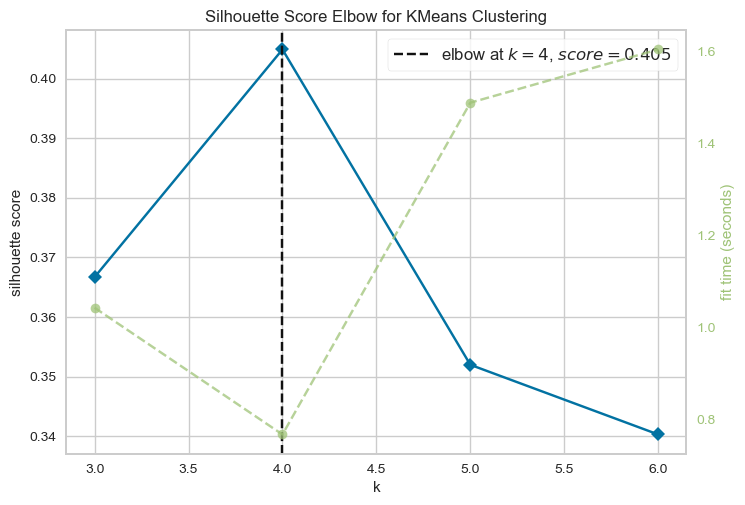

In [19]:
# Appel de la fonction pour détermination de nombre de cluster par la méthode du coefficient de silhouette
calcul_nbre_cluster_kmeans(X,3,7,'silhouette')

La méthode du coude donne k=5 et selon le coefficient de silhouette le nombre de k optimal serait 4. 
Regardons la répartition des clients en clusters en fonction du nombre de k

114941.74707053641
la repartition des clients par 3 clusters


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\297356497.py:22: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



Clusters,Nb_clients,%
0,2428,2.690000
1,37288,41.320000
2,50532,55.990000


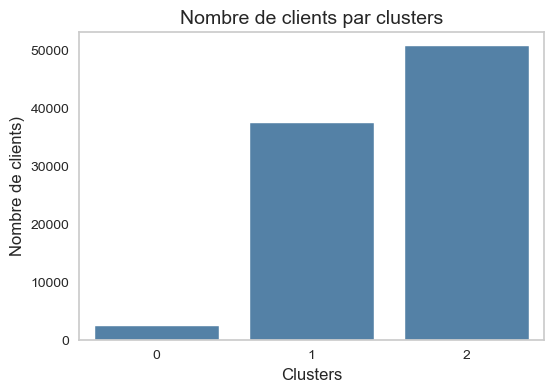

73687.11794844977
la repartition des clients par 4 clusters


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\297356497.py:22: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



Clusters,Nb_clients,%
0,16685,18.490000
1,2428,2.690000
2,41177,45.630000
3,29958,33.200000


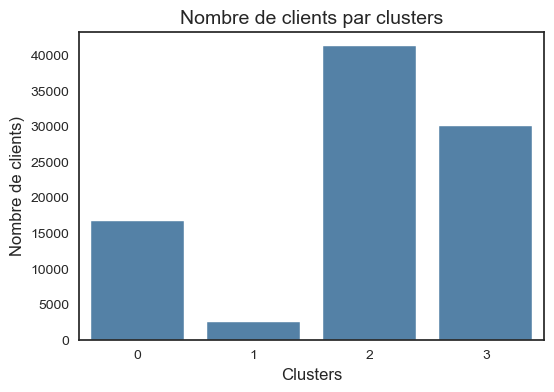

60578.725913530594
la repartition des clients par 5 clusters


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\297356497.py:22: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



Clusters,Nb_clients,%
0,26352,29.200000
1,24856,27.540000
2,11304,12.530000
3,2428,2.690000
4,25308,28.040000


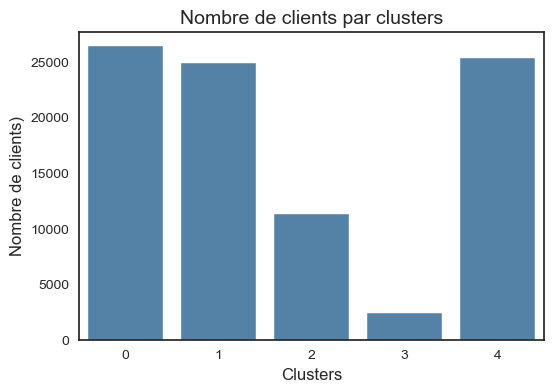

50923.064607539556
la repartition des clients par 6 clusters


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\297356497.py:22: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



Clusters,Nb_clients,%
0,24530,27.180000
1,20670,22.900000
2,2428,2.690000
3,11784,13.060000
4,21791,24.150000
5,9045,10.020000


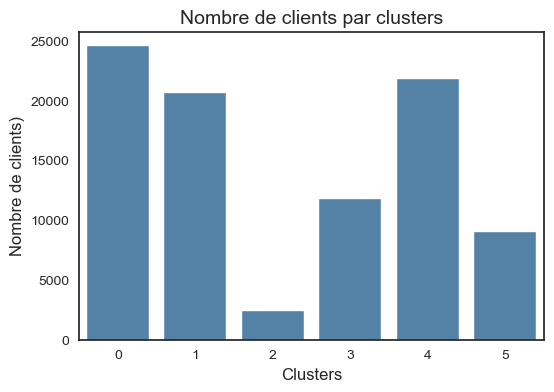

In [20]:
'''la répartition des clients en clusters en fonction du nombre de k'''
for k in range(3,7):
    model = KMeans(n_clusters=k)
    model.fit(X)
    model_labels=model.labels_
    print(model.inertia_)
    print("la repartition des clients par", k, "clusters")
    clients_par_clusters(model_labels)

Nous choisissons la répartition en 4 clusters

le score est 73687.2374601883


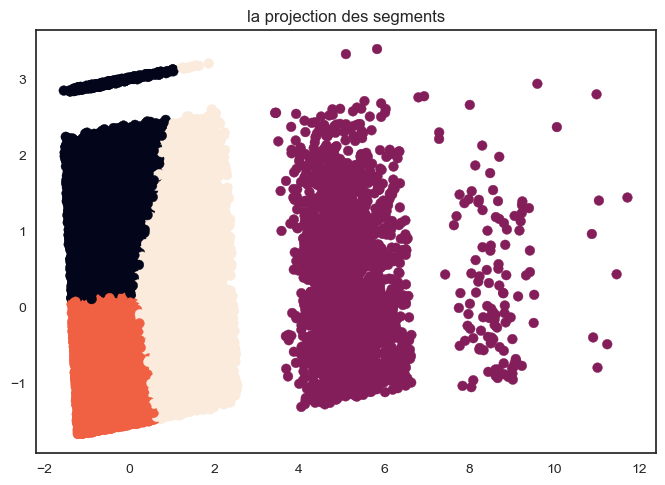

In [71]:
model_labels=clustering(X,4,2)

In [22]:
data_km=table.copy()


#### Caractéristiques des clusters RFM

In [23]:
def snake_plot(df, var):

    # Melt data into long format
    df_melt = pd.melt(df.reset_index(), 
                        id_vars=['customer_unique_id', 'cluster'],
                        value_vars=var, 
                        var_name='Metric', 
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='cluster')
    plt.title('Snake Plot des différents clusters', fontsize='18')
    
    return

In [24]:
#fonction qui donne la moyenne des features 
def rfm_mean_stats(df):
    df_new = df.groupby(['cluster']).agg({'mean'
                                         }).round(0)
    df_new['count']=df['cluster'].value_counts()
    return df_new

In [25]:
#fonction qui calcule plusieurs indicateurs statistiques 
def rfm_clusters_stats(df):
    df_new = df.groupby(['cluster']).agg({'mean','median','min','max'
                                         }).round(0)
    df_new['count']=df['cluster'].value_counts()
    return df_new

In [27]:
#Fonction de visualisation des clusters
def visualisation_cluster(data,model_labels,var_rfm):
    #création de la colonne cluster
    data['cluster']=model_labels
    #calcul de la moyenne des feautures par cluster
    rfm_clusters_stats(data)
    #creation de la dataframe 
    data_stats=pd.DataFrame(rfm_clusters_stats(data))
    #visualisation des segments 
    plt.figure(figsize=(10, 6))
    squarify.plot(sizes=data_stats["count"], label=data_stats.index, color=["b","g","r","m","c", "y"], alpha=0.7)
    plt.suptitle("segmentation des clients", fontsize=25)
    
    # Visualisation graphique features selon les labels
    plt.figure(figsize=(15, 20))
    for col, x in zip(var_rfm,
                  range(1, len(data.columns))):
        plt.subplot(3,2,x)
        sns.boxplot(y=col, x='cluster',
        data=data, showfliers=False)
        plt.title('la repartition de la variable '+col , fontsize='18')
    plt.show()
    #snake plot 
    snake_plot(data,var_rfm)
    return data, data_stats

In [28]:
var_rfm=['rfm_recence', 'rfm_frequence', 'rfm_montant']

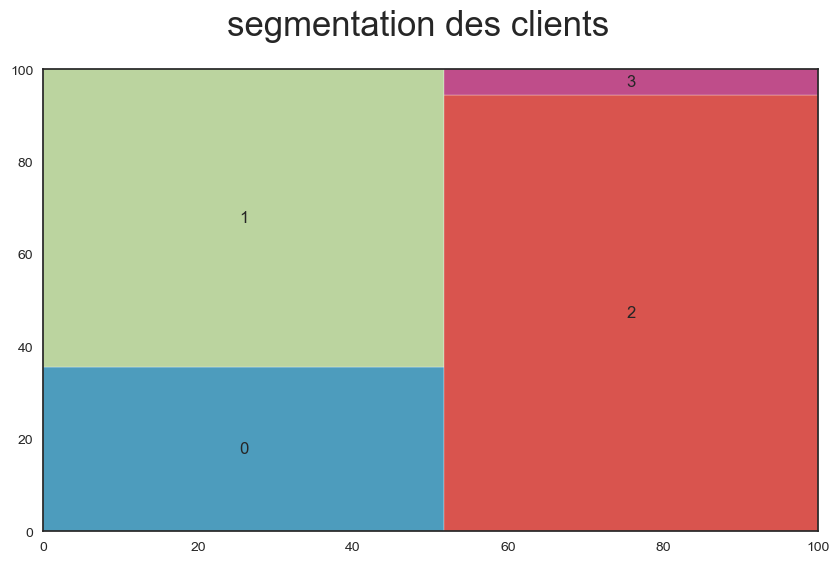

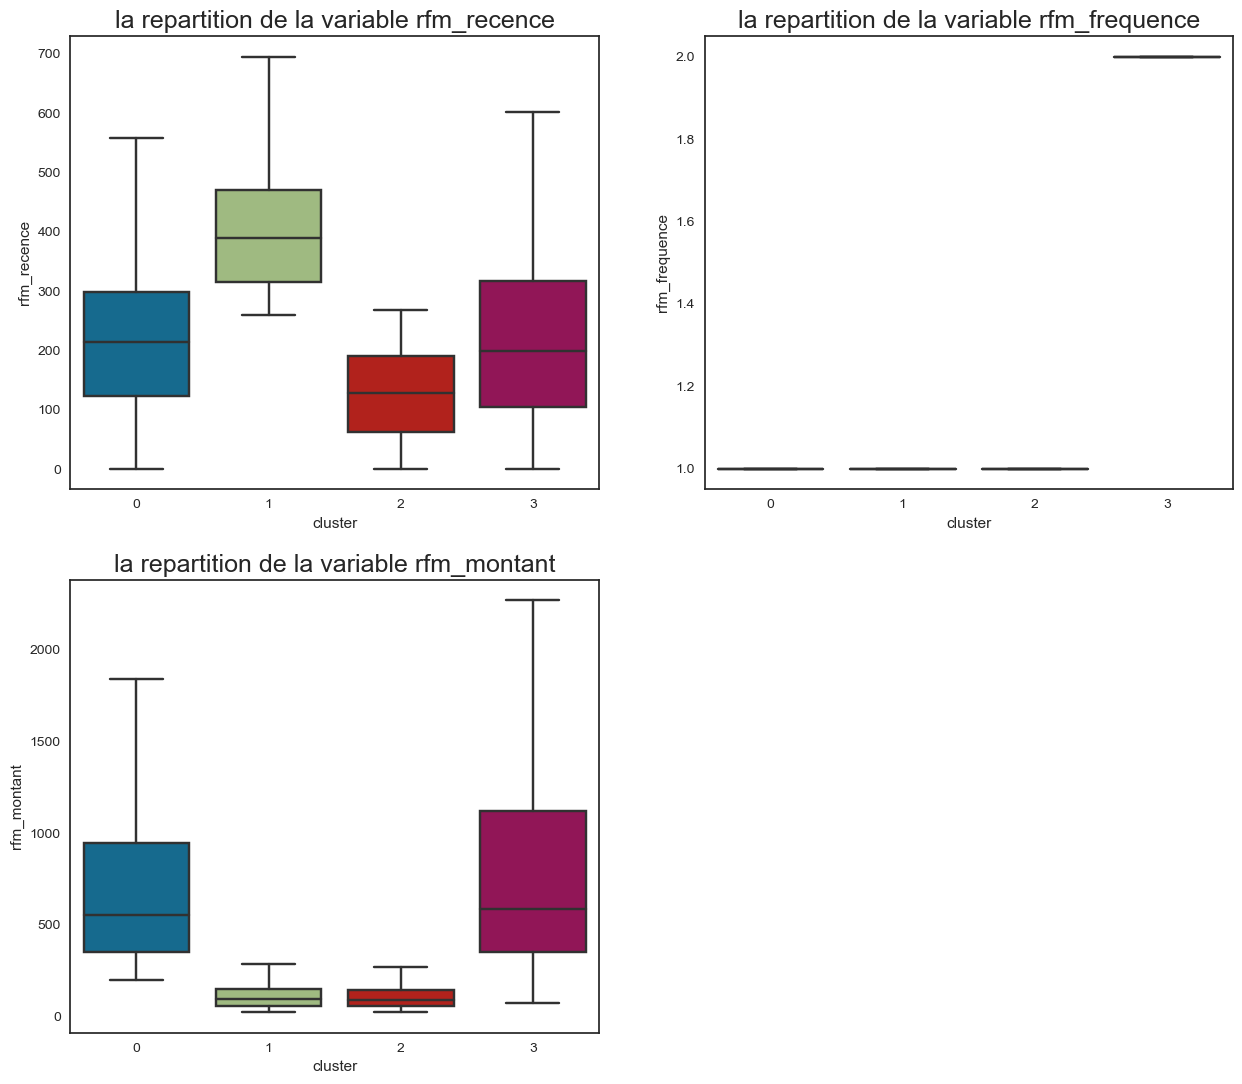

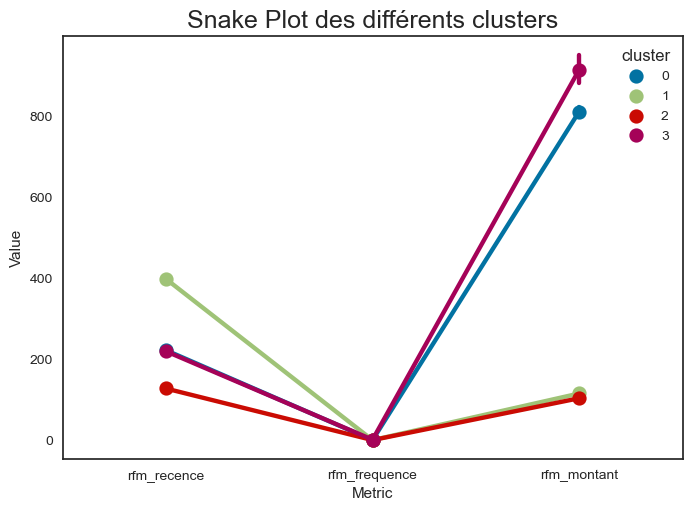

In [29]:
data_km,data_km_mean=visualisation_cluster(data_km,model_labels,var_rfm)

In [30]:
data_km_mean

rfm_recence                      rfm_frequence                   \
                max median    min   mean           max median  min mean   
cluster                                                                   
0             694.0  215.0    1.0  223.0           1.0    1.0  1.0  1.0   
1             695.0  389.0  260.0  398.0           1.0    1.0  1.0  1.0   
2             269.0  128.0    1.0  128.0           1.0    1.0  1.0  1.0   
3             692.0  200.0    1.0  220.0           4.0    2.0  2.0  2.0   

        rfm_montant                       count  
                max median    min   mean         
cluster                                          
0            5264.0  551.0  196.0  811.0  16648  
1            1003.0   93.0   23.0  116.0  30058  
2             337.0   91.0   23.0  104.0  41114  
3            5197.0  583.0   75.0  914.0   2428

#### Profils des clients par clusters


- **Cluster 0**: les clients qui ont un **montant élevé**, une **fréquence moyenne d'une commande** et une **récence moyenne**


- **Cluster 1**: les clients qui ont un **montant faible**, une **fréquence moyenne d'une commande** et une **récence élevée**


- **Cluster 2**:les clients qui ont un **montant faible**, une **fréquence moyenne d'une commande** et une **récence faible**


- **Cluster 3**: les clients qui ont un **montant élevé**, une **fréquence moyenne de deux commandes** et une **récence moyenne**

#### Segmentation avec 4 variables
Réalisons une simulation avec une variable suplémentaire. Nous choisissons la variable 'review_mean_score' correpondant à la moyenne des notation des clients, donc à leur satisfaction.

In [31]:
# selections des variables 
four_feats=['customer_unique_id','rfm_recence', 'rfm_frequence', 'rfm_montant','review_mean_score']

In [32]:
data_sc=df[four_feats]
data_sc.set_index('customer_unique_id', inplace=True)

In [33]:
#selection
X_sc,Y=selection_features(df_log,four_feats)
#normalisation
X_sc=scaler(X_sc)


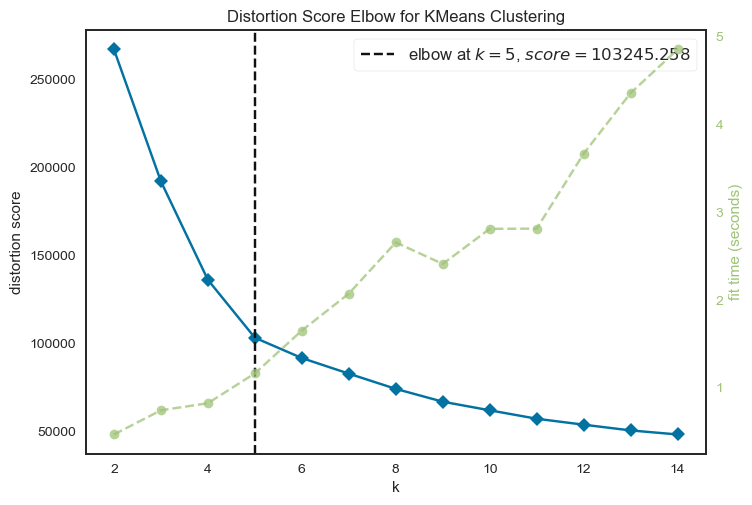

In [34]:
calcul_nbre_cluster_kmeans(X_sc,2,15,'distortion')

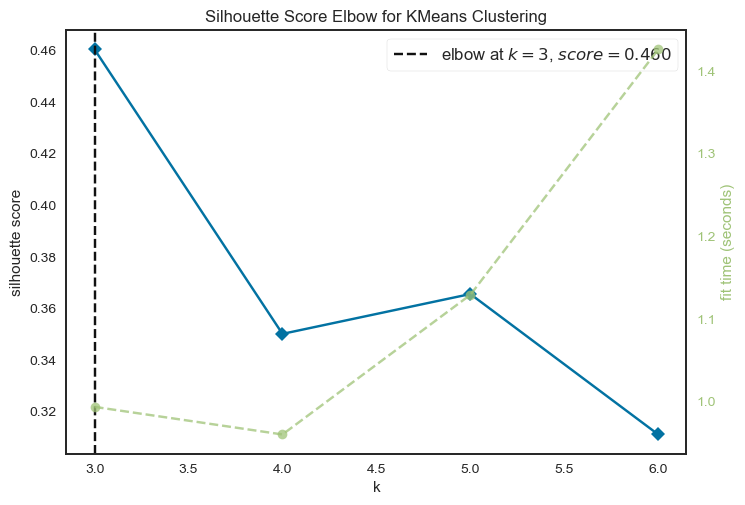

In [35]:
calcul_nbre_cluster_kmeans(X_sc,3,7,'silhouette')

La méthode du coude donne k=5 et le nombre de k qui maximise le silhoette score est de 3. 
Regardons la répartition des clients en clusters en fonction du nombre de k

192151.19746445946


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\297356497.py:22: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



Clusters,Nb_clients,%
0,2428,2.690000
1,11122,12.320000
2,76698,84.990000


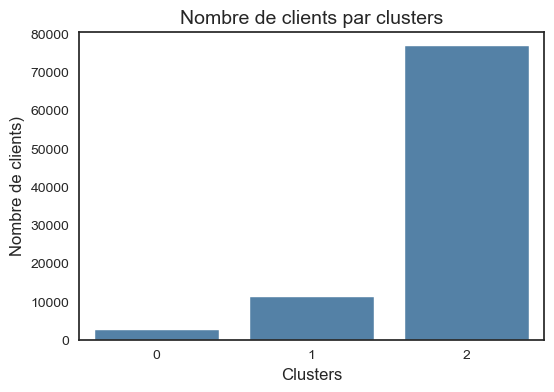

136168.85787457437


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\297356497.py:22: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



Clusters,Nb_clients,%
0,33099,36.680000
1,43829,48.570000
2,2428,2.690000
3,10892,12.070000


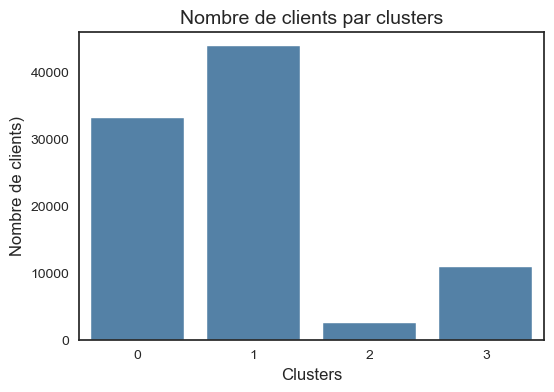

103246.0563745215


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\297356497.py:22: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



Clusters,Nb_clients,%
0,36253,40.170000
1,14061,15.580000
2,2428,2.690000
3,10559,11.700000
4,26947,29.860000


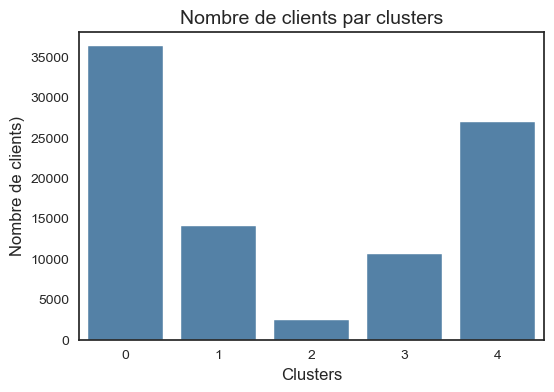

91703.17908087326


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\297356497.py:22: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



Clusters,Nb_clients,%
0,22778,25.240000
1,2428,2.690000
2,23174,25.680000
3,10481,11.610000
4,9475,10.500000
5,21912,24.280000


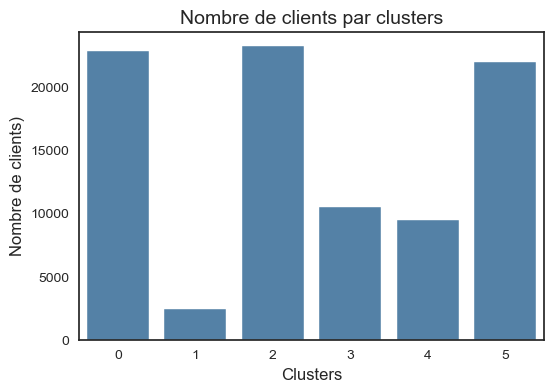

In [36]:
for k in range(3,7):
    model = KMeans(n_clusters=k)
    model.fit(X_sc)
    model_labels=model.labels_
    print(model.inertia_)
    clients_par_clusters(model_labels)

le score est 103246.2628968946


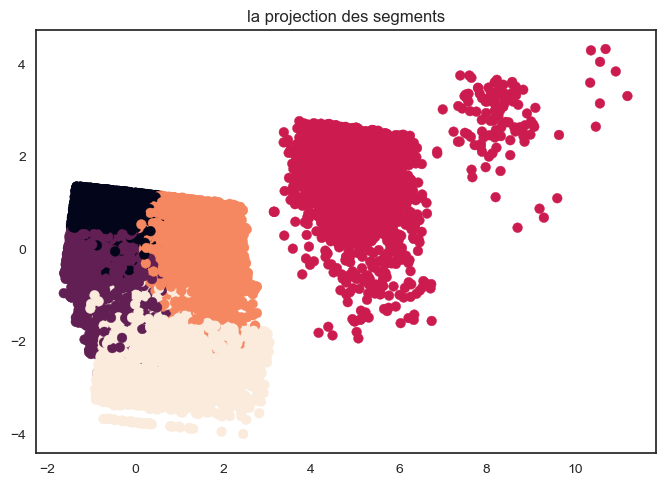

In [72]:
model_labels_sc=clustering(X_sc,5,3)

In [38]:
feats_sc=data_sc.columns.to_list()

C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\4155500572.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



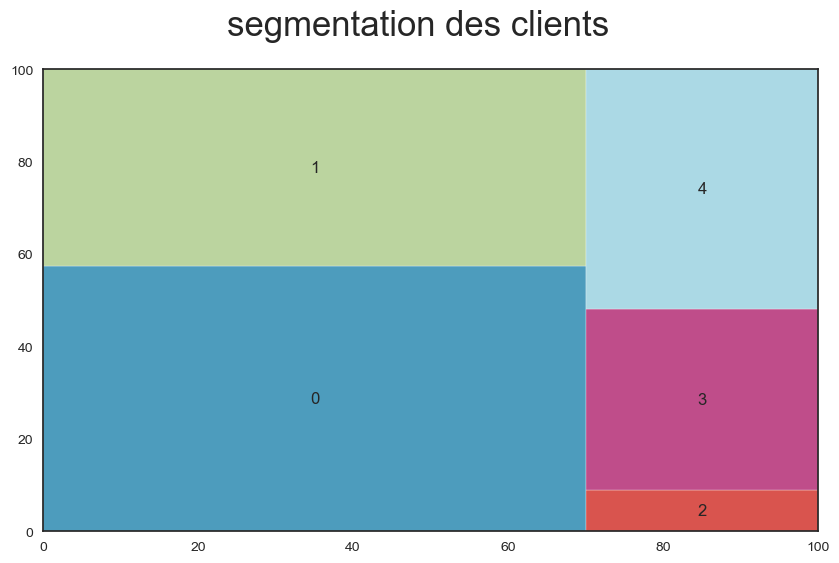

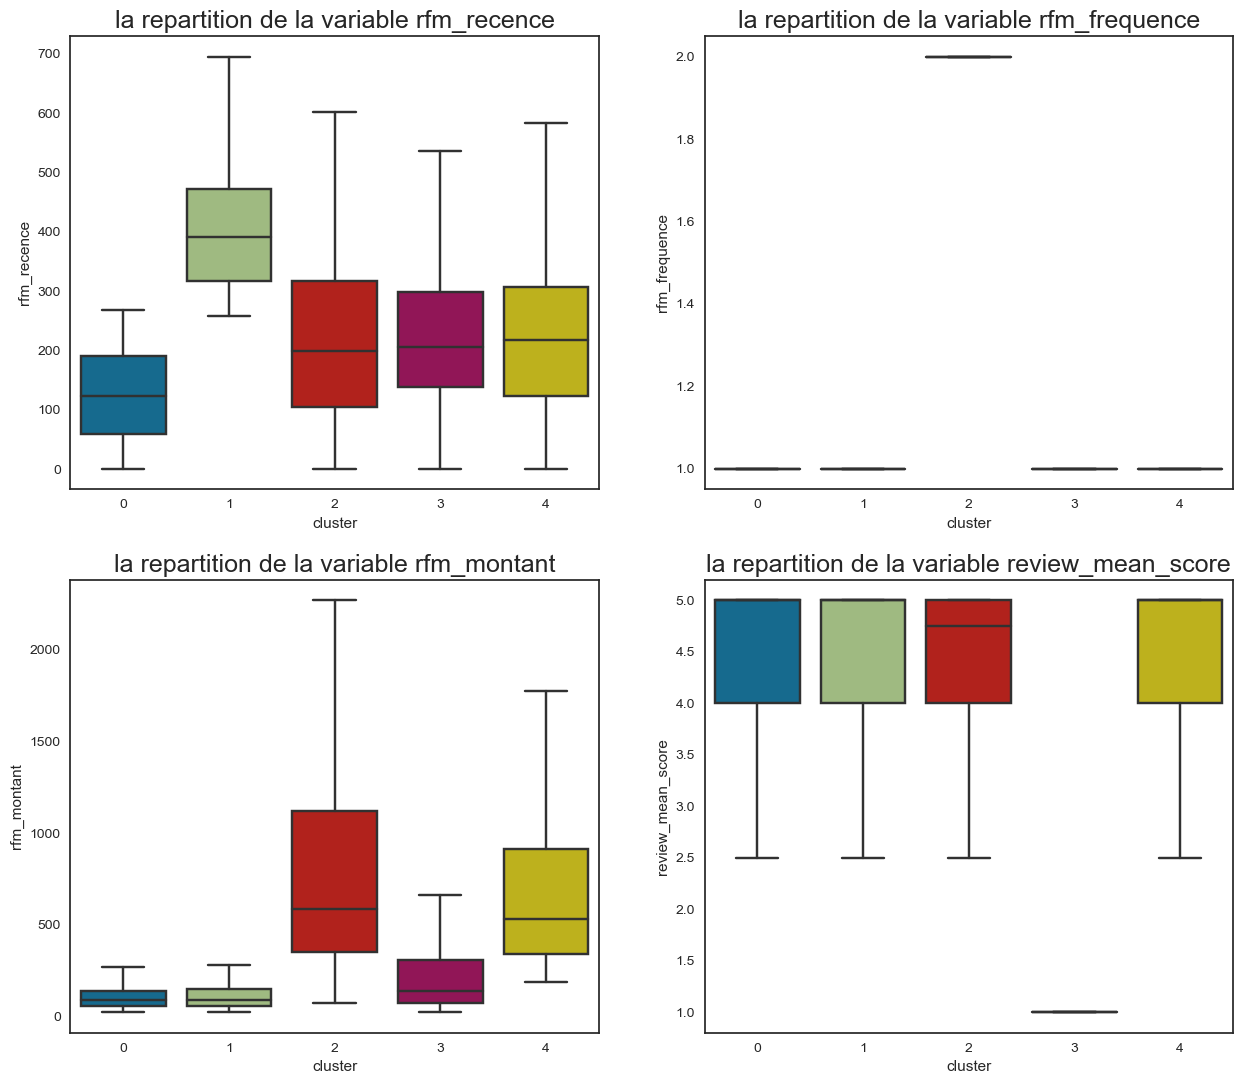

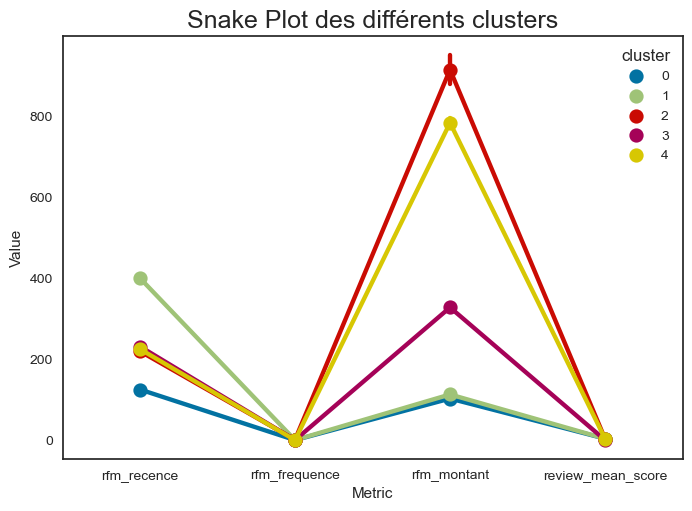

In [39]:
data_sc,data_sc_mean=visualisation_cluster(data_sc,model_labels_sc,feats_sc)

In [40]:
data_sc_mean

rfm_recence                      rfm_frequence                   \
                max median    min   mean           max median  min mean   
cluster                                                                   
0             268.0  124.0    1.0  126.0           1.0    1.0  1.0  1.0   
1             695.0  391.0  258.0  400.0           1.0    1.0  1.0  1.0   
2             692.0  200.0    1.0  220.0           4.0    2.0  2.0  2.0   
3             695.0  206.0    1.0  232.0           1.0    1.0  1.0  1.0   
4             694.0  218.0    1.0  225.0           1.0    1.0  1.0  1.0   

        rfm_montant                      review_mean_score                   \
                max median    min   mean               max median  min mean   
cluster                                                                       
0             337.0   90.0   23.0  103.0               5.0    5.0  2.0  5.0   
1            1003.0   91.0   23.0  113.0               5.0    5.0  2.0  5.0   
2            5197.0  583.0   75.0  914.0               5.0    5.0  1.0  4.0   
3            5221.0  137.0   23.0  328.0               2.0    1.0  1.0  1.0   
4            5264.0  528.0  187.0  783.0               5.0    5.0  2.0  5.0   

         count  
                
cluster         
0        36255  
1        26967  
2         2428  
3        10559  
4        14039

#### Profils des clients par clusters


- Cluster 0: Des **clients satisfaits**, qui ont passé leur **dernière commande récemment** d'un **montant d'achat faible** 


- Cluster 1: Des **clients satisfaits**, qui ont passé leur **dernière commande il y a longtemps** d'un **montant d'achat faible** 

- Cluster 2: Des **clients satisfaits**, qui ont un montant de **dépense élevé**, et qui **commandent plus souvent**


- Cluster 3: Des **clients non satisfaits**, qui ont un montant de **dépense faible** et qui ont une **fréquence moyenne d'une commande** 


- Cluster 4: Des **clients satisfaits**, qui ont un montant de **dépense élevé**, mais qui **ne commandent pas souvent**


#### Segmentation avec des variables supplémentaires
Réalisons une nouvelle simulation avec des variables suplémentaires. Nous choisissons la variable 'nombre_produits' correpondant au nombre total de produits achetés par le client et la variable 'echéances' qui correspond au nombre de paiements.

In [41]:
new_feats=['customer_unique_id','rfm_recence', 'rfm_frequence', 'rfm_montant','review_mean_score','nombre_produits','echeances']

In [42]:
data_nf=df[new_feats]
data_nf.set_index('customer_unique_id', inplace=True)

In [43]:
#selection
X_nf,Y=selection_features(df_log,new_feats)
#normalisation
X_nf=scaler(X_nf)

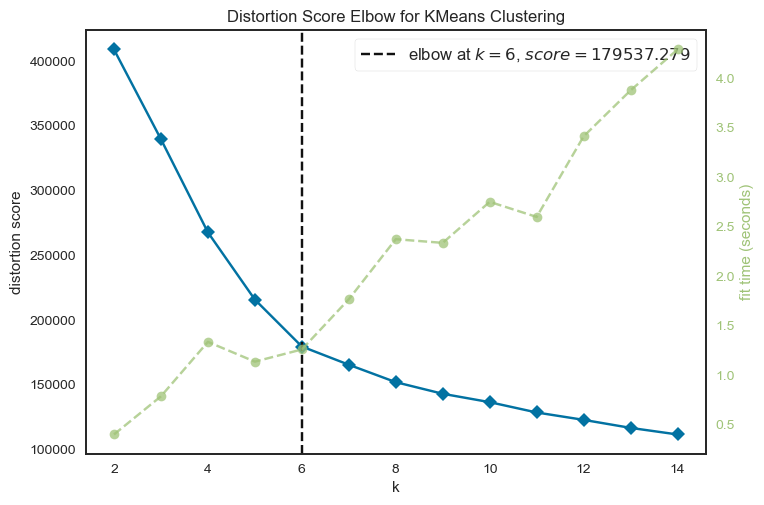

In [44]:
calcul_nbre_cluster_kmeans(X_nf,2,15,'distortion')

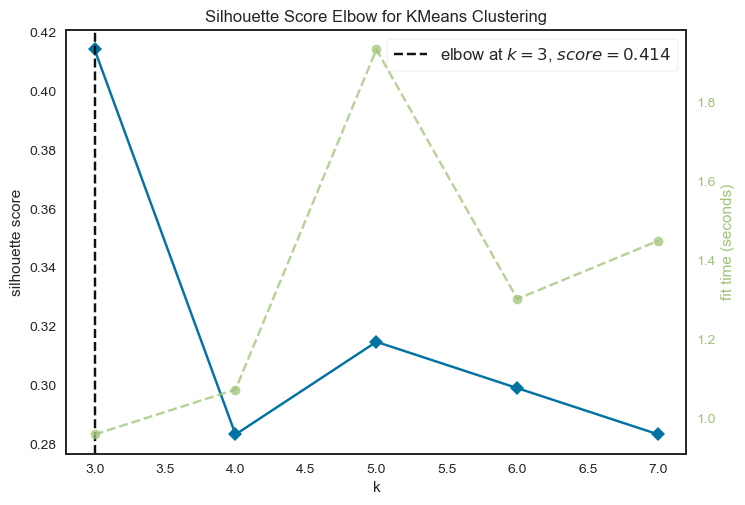

In [45]:
calcul_nbre_cluster_kmeans(X_nf,3,8,'silhouette')

Nous choisissons k=6 donné par la methode du coude 

#### Caractéristiques des clusters

le score est 179537.80938229625


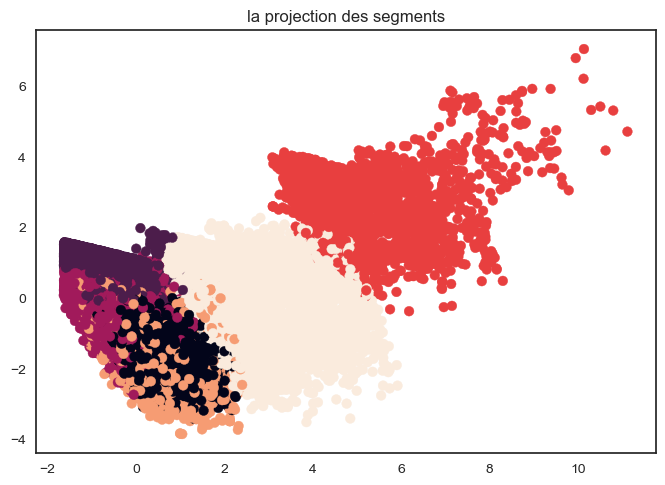

In [73]:
model_labels_nf=clustering(X_nf,6,2)

In [47]:
feats_nf=data_nf.columns.to_list()

C:\Users\mr_ar\AppData\Local\Temp\ipykernel_7676\4155500572.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



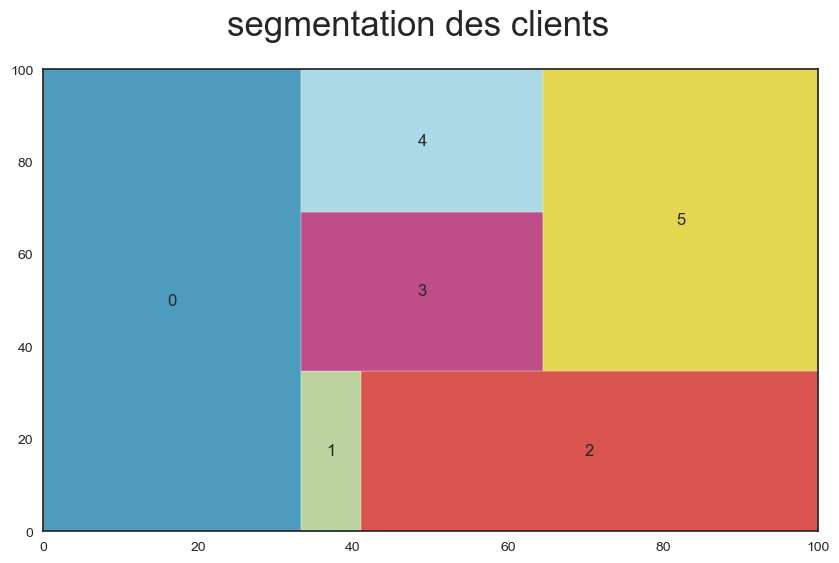

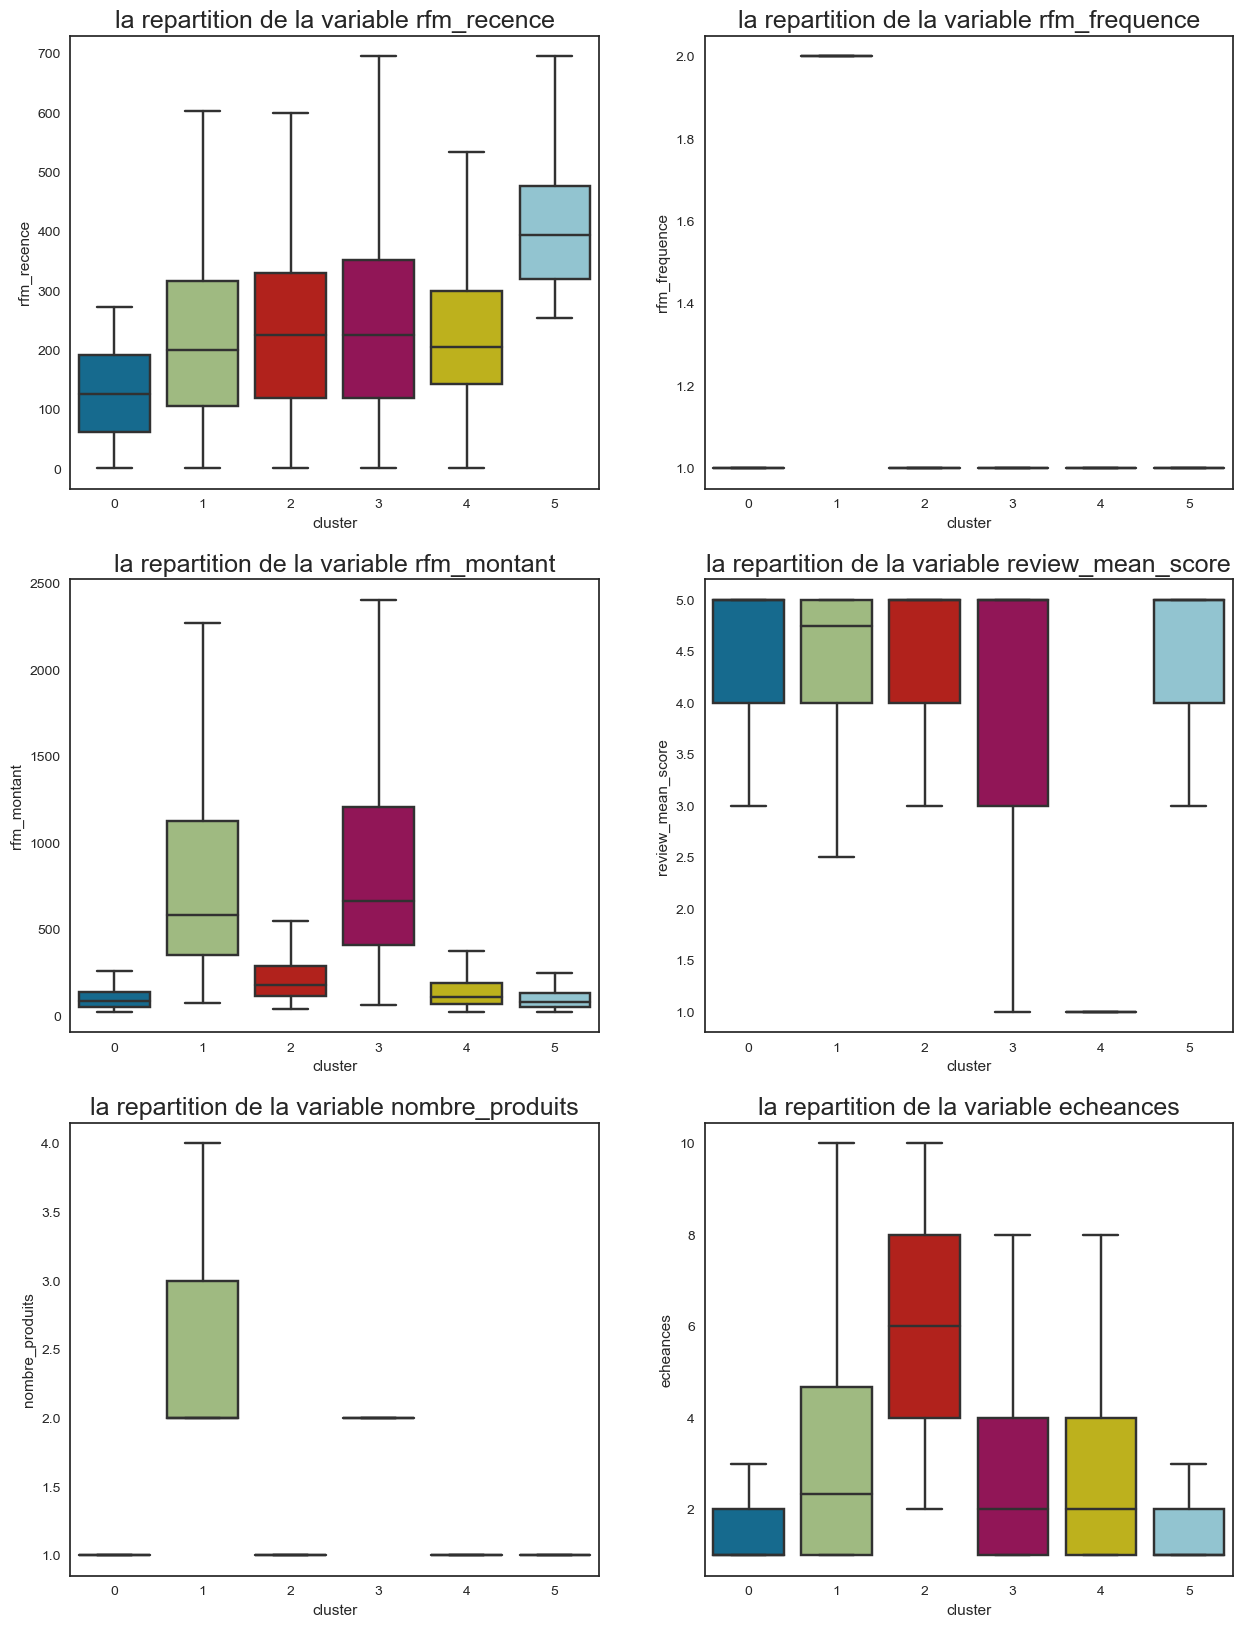

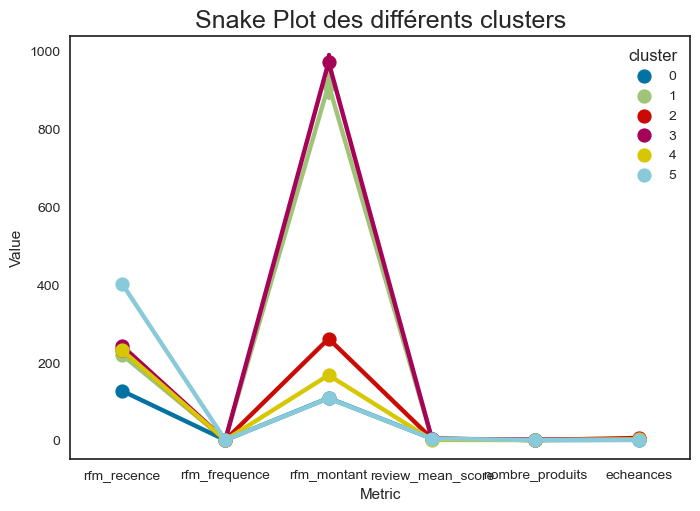

In [48]:
data_nf,data_nf_mean=visualisation_cluster(data_nf,model_labels_nf,feats_nf)

In [63]:
data_nf_mean

rfm_recence                      rfm_frequence                   \
                max median    min   mean           max median  min mean   
cluster                                                                   
0             273.0  126.0    1.0  128.0           1.0    1.0  1.0  1.0   
1             692.0  200.0    1.0  220.0           4.0    2.0  2.0  2.0   
2             695.0  225.0    1.0  234.0           1.0    1.0  1.0  1.0   
3             695.0  225.0    1.0  243.0           1.0    1.0  1.0  1.0   
4             695.0  205.0    1.0  232.0           1.0    1.0  1.0  1.0   
5             695.0  393.0  254.0  403.0           1.0    1.0  1.0  1.0   

        rfm_montant         ... review_mean_score nombre_produits              \
                max median  ...              mean             max median  min   
cluster                     ...                                                 
0            2713.0   83.0  ...               5.0             2.0    1.0  1.0   
1            5197.0  583.0  ...               4.0             4.0    2.0  2.0   
2            4764.0  174.0  ...               5.0             1.0    1.0  1.0   
3            5264.0  663.0  ...               4.0             4.0    2.0  1.0   
4            3184.0  108.0  ...               1.0             2.0    1.0  1.0   
5            3602.0   78.0  ...               5.0             2.0    1.0  1.0   

             echeances                   count  
        mean       max median  min mean         
cluster                                         
0        1.0       5.0    1.0  1.0  1.0  30053  
1        2.0      10.0    2.0  1.0  3.0   2428  
2        1.0      10.0    6.0  2.0  6.0  18517  
3        2.0      10.0    2.0  1.0  3.0   9700  
4        1.0      10.0    2.0  1.0  3.0   8678  
5        1.0       9.0    1.0  1.0  2.0  20872  

[6 rows x 25 columns]

#### Profils des clients par clusters


- Cluster 0: Des **clients satisfaits**, qui ont passé leur **dernière commande récemment** d'un **montant d'achat faible** et qui **n'achètent pas beaucoup de produits**


- Cluster 1: Des **clients satisfaits**, qui **commandent plus souvent** , **achètent beaucoup plus de produits**, avec un **montant d'achat élevé** 


- Cluster 2: Des **clients satisfaits**, qui ont un montant de **dépense faible**, et qui **réalisent des paiments en 6 fois en moyenne**


- Cluster 3: Des **clients satisfaits**, qui **commandent ne commnadent pas souvent** mais qui ont un **montant d'achat élevé** 


- Cluster 4: Des **clients non satisfaits**,qui ont un **montant d'achat faible** et qui **n'achètent pas beaucoup de produits**


- Cluster 5: Des **clients satisfaits**, qui ont passé leur **dernière commande il y a longtemps** d'un **montant d'achat faible** et qui **n'achètent pas beaucoup de produits**

## Test d'autres algorithmes

### DBscan

Le DBSCAN est un algorithme simple qui définit des clusters en utilisant l’estimation de la densité locale. On peut le diviser en 4 étapes :

- Pour chaque observation on regarde le nombre de points à au plus une distance ε de celle-ci. On appelle cette zone le ε-voisinage de l’observation.
- Si une observation compte au moins un certain nombre de voisins y compris elle-même, elle est considérée comme une observation cœur. On a alors décelé une observation à haute densité.
- Toutes les observations au voisinage d’une observation cœur appartiennent au même cluster. Il peut y avoir des observations cœur proche les unes des autres. Par conséquent de proche en proche on obtient une longue séquence d’observations cœur qui constitue un unique cluster.
- Toute observation qui n’est pas une observation cœur et qui ne comporte pas d’observation cœur dans son voisinage est considérée comme une anomalie.


On a donc besoin de définir deux informations avant d’utiliser le DBSCAN :

Quelle distance ε pour déterminer pour chaque observation le ε-voisinage ? Quel est le nombre minimal de voisins nécessaire pour considérer qu’une observation est une observation cœur ?

nous allons chercher à déterminer le ε optimal pour obtenir un meilleur partitionnement de notre jeu de données. 

In [50]:
X_db=X_nf.copy()

Text(0, 0.5, 'Distance')

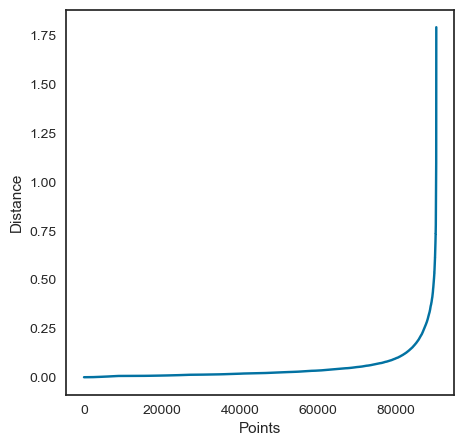

In [64]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=2)
neighbors = nearest_neighbors.fit(X_db)

distances, indices = neighbors.kneighbors(X_db)
distances = np.sort(distances[:, 1], axis=0)
fig = plt.figure(figsize=(5,5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

0.09042132049596756


<Figure size 300x300 with 0 Axes>

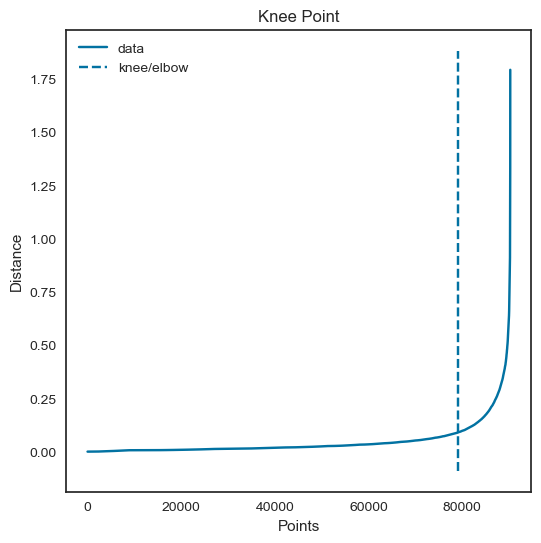

In [66]:
#Identifying Elbow Point with Kneed Package 
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(3,3))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

Estimated no. of clusters: 2
Estimated no. of noise points: 78151


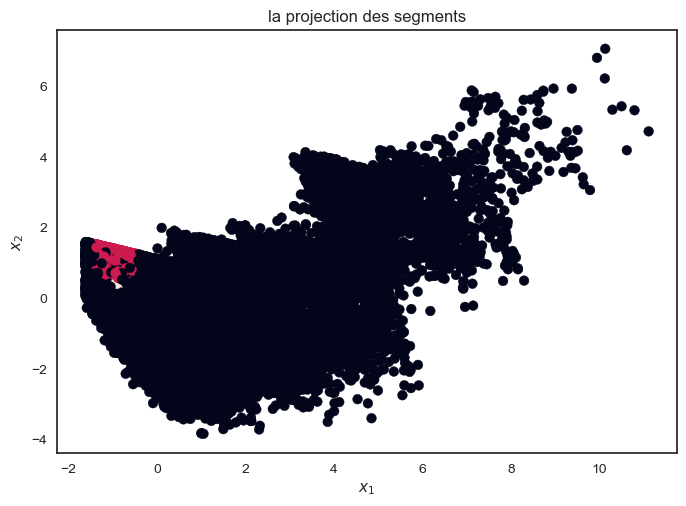

In [74]:
dbscan_cluster = DBSCAN(eps=0.09, min_samples=100)
dbscan_cluster.fit(X_db)

#Apc pour une meilleure projection
pca = PCA(n_components=2)
pca.fit(X_db)
X_db_trans=pca.transform(X_db)
# Visualizing DBSCAN
plt.scatter(X_db_trans[:, 0], 
X_db_trans[:, 1], 
c=dbscan_cluster.labels_)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title('la projection des segments')

# Number of Clusters
labels=dbscan_cluster.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan_cluster.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)


#### Agglomerative Clustering

Dans le cas du clustering agglomératif (ou bottom-up), on commence par considérer que chaque point est un cluster à lui tout seul. Ensuite, on trouve les deux clusters les plus proches, et on les agglomère en un seul cluster. On répète cette étape jusqu'à ce que tous les points appartiennent à un seul cluster, constitué de l'agglomération de tous les clusters initiaux.

In [67]:
X_agc=pd.DataFrame(X_nf)

le clustering hiérarchique est plus adapté aux échantillons contenant un faible nombre d'individus. Nous allons donc travailler sur un sample du fichier.

In [56]:
#sample du fichier 
X_ag= X_agc.sample(10000, random_state=42).copy()

In [57]:
#rnd_indices = np.random.choice(len(X_nf), size=10000,replace=False)

#X_ag= X_nf[rnd_indices]

#### Dendogramme

Un dendrogramme est un arbre dont les feuilles sont les points d'un jeu de données. Chaque nœud de l'arbre représente un cluster (les feuilles sont des clusters contenant un point chacun). Les clusters qui ont le même parent sont agglomérés pour former ce cluster parent. La longueur des U est proportionnelle à la distance entre les deux clusters qu'ils connectent.

In [58]:
pca = PCA(n_components = 2)
X_p = pca.fit_transform(X_ag)

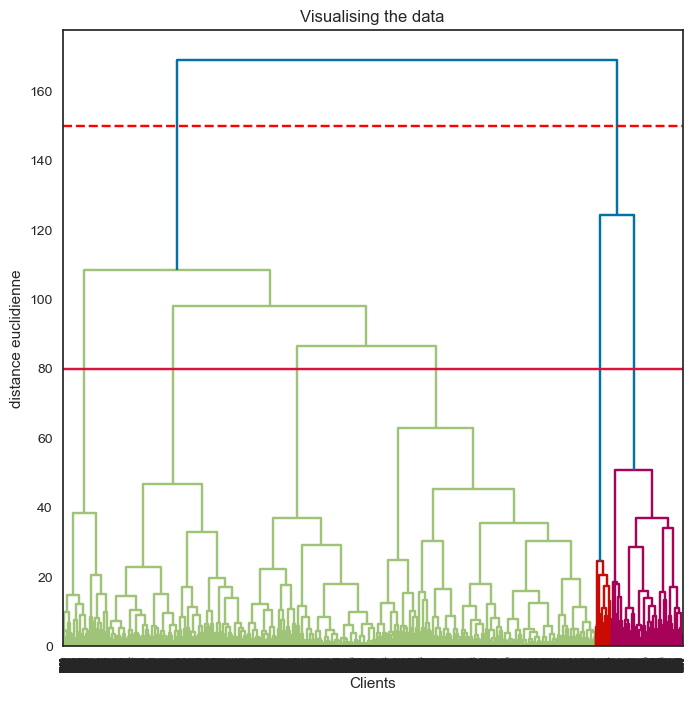

In [68]:
plt.figure(figsize =(8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_ag, method ='ward')))
plt.xlabel('Clients')
plt.ylabel('distance euclidienne') 
# traçons une droite  horizontale qui représente une grande distance entre les clusters  
plt.axhline(150, color='red', linestyle='--')
# traçons une deuxieme droite  horizontale qui représente une distance entre les clusters 
plt.axhline(80,color='crimson')
plt.show()

les résultats sont assez similaires au K-means. Nous obtenons 6 clusters

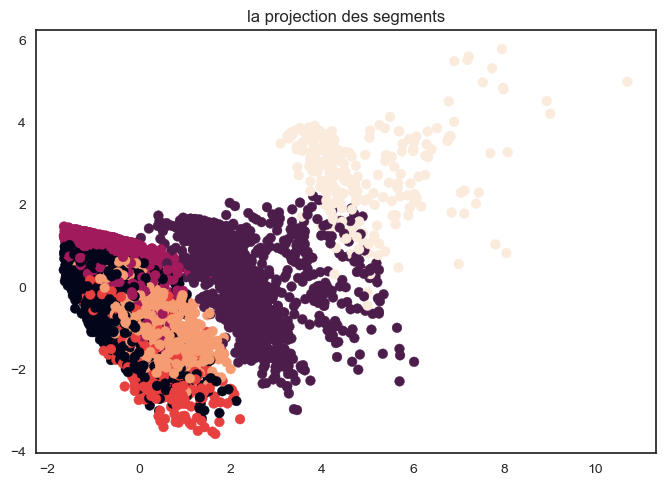

In [75]:
agg = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage = 'ward')
aggloclust=agg.fit(X_ag)
labels = aggloclust.labels_
plt.scatter(X_p[:,0], X_p[:,1], c=labels)
plt.title('la projection des segments')
plt.show()